# Join ERP data to sensor data

This notebook downloads ERP data from google sheets (`df2gspread`) and then joins it to sensor data from `001`.

1. Download HARVEST and PLANT from gsheets
1. Join HARVEST and PLANT based on tray and timestamps to create lifetimes
1. Join aggregated SENSOR onto lifetimes (WIP)


In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from df2gspread import gspread2df as g2d
import seaborn as sns

pd.set_option('display.max_rows', 10)

%matplotlib inline

# Load up ERP data sources
From [this](https://docs.google.com/spreadsheets/d/1ehmVZ44CIWByLqZMsqfkDkqsG9kwwtRJg7cxVMCRnNE/edit#gid=1027781493) google sheet.

In [2]:
import re

def erp_rack_parser(s):
    resp = {'RACK': None, 'RACK_EXCEPTION': ''}
    try:
        resp['RACK'] = int(re.findall(r'Rack (\d+)', s)[0])
    except Exception as e:
        resp['RACK_EXCEPTION'] = str(e)
    return pd.Series(resp)

def erp_tray_parser(s):
    resp = {'TRAY': None, 'TRAY_EXCEPTION': ''}
    try:
        resp['TRAY'] = int(re.findall(r'Tray (\d+)', s)[0])
    except Exception as e:
        resp['TRAY_EXCEPTION'] = str(e)
    return pd.Series(resp)

## `PLANT` $\rightarrow$ `df_plant`

In [3]:
df_plant_raw = g2d.download('1ehmVZ44CIWByLqZMsqfkDkqsG9kwwtRJg7cxVMCRnNE', wks_name='PLANT', col_names=True)
df_plant_raw

,Date,Plant type,Tray ID,Rack,Level,Position,Seeded (date),Filling rate,Other comments,ID,Last Harvest
0,15.05.2018,Thai basil,Tray 133,Rack 1,Level 1 (bottom),Right,,,,Tray 13343235,18.10.2018
1,15.05.2018,Thai basil,Tray 030,Rack 1,Level 1 (bottom),Center,,,,Tray 03043235,
2,15.05.2018,Thai basil,Tray 141,Rack 1,Level 1 (bottom),Left,,,,Tray 14143235,
3,15.05.2018,Thai basil,Tray 137,Rack 1,Level 2,Center,,,,Tray 13743235,26.10.2018
4,15.05.2018,Thai basil,Tray 134,Rack 1,Level 2,Right,,,,Tray 13443235,
...,...,...,...,...,...,...,...,...,...,...,...
293,,,,,,,,,,,#N/A
294,,,,,,,,,,,#N/A
295,,,,,,,,,,,#N/A
296,,,,,,,,,,,#N/A


In [54]:
# cleanse the ERP data
df_plant = df_plant_raw[df_plant_raw.Rack.notnull() & (~df_plant_raw.Rack.isin(['','NA','#N/A',]))].copy()
df_plant['DATE_PLANTED'] = pd.core.tools.datetimes.to_datetime(df_plant.Date)
df_plant['DATE_SEEDED'] = pd.core.tools.datetimes.to_datetime(df_plant['Seeded (date)'], errors='ignore')
df_plant[['TRAY', 'TRAY_EXCEPTION']] = df_plant['Tray ID'].apply(erp_tray_parser)
df_plant[['RACK', 'RACK_EXCEPTION']] = df_plant['Rack'].apply(erp_rack_parser)
df_plant['PLANT_PLANTED'] = df_plant['Plant type']
df_plant = df_plant.rename(columns={"Rack": "Rack (raw)"})
df_plant

,Date,Plant type,Tray ID,Rack (raw),Level,Position,Seeded (date),Filling rate,Other comments,ID,Last Harvest,DATE_PLANTED,DATE_SEEDED,TRAY,TRAY_EXCEPTION,RACK,RACK_EXCEPTION,PLANT_PLANTED
0,15.05.2018,Thai basil,Tray 133,Rack 1,Level 1 (bottom),Right,,,,Tray 13343235,18.10.2018,2018-05-15,NaT,133.0,,1,,Thai basil
1,15.05.2018,Thai basil,Tray 030,Rack 1,Level 1 (bottom),Center,,,,Tray 03043235,,2018-05-15,NaT,30.0,,1,,Thai basil
2,15.05.2018,Thai basil,Tray 141,Rack 1,Level 1 (bottom),Left,,,,Tray 14143235,,2018-05-15,NaT,141.0,,1,,Thai basil
3,15.05.2018,Thai basil,Tray 137,Rack 1,Level 2,Center,,,,Tray 13743235,26.10.2018,2018-05-15,NaT,137.0,,1,,Thai basil
4,15.05.2018,Thai basil,Tray 134,Rack 1,Level 2,Right,,,,Tray 13443235,,2018-05-15,NaT,134.0,,1,,Thai basil
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267,26.10.2018,Thai basil,Tray 017,Rack 2,Level 1 (bottom),Left,12.10.2018,,LOG,Tray 01743399,,2018-10-26,2018-12-10,17.0,,2,,Thai basil
268,26.10.2018,Thai basil,Tray 066,Rack 2,Level 1 (bottom),Left,12.10.2018,,Solhatt,Tray 06643399,,2018-10-26,2018-12-10,66.0,,2,,Thai basil
269,16.10.2018,Ruccola test,Tray 058,Rack 4,Level 3,Center,09.10.2018,,,Tray 05843389,,2018-10-16,2018-09-10,58.0,,4,,Ruccola test
270,01.08.2018,Mint,Tray 068,Rack 1,Level 4,Center,,,,Tray 06843313,19.09.2018,2018-01-08,NaT,68.0,,1,,Mint


In [55]:
print(df_plant.RACK.value_counts(dropna=False))
print(df_plant.TRAY.value_counts(dropna=False))

assert df_plant.Date.isnull().sum() == 0

2    84
1    77
5    62
4    49
Name: RACK, dtype: int64
90.0     5
47.0     5
133.0    4
139.0    4
57.0     4
        ..
129.0    1
117.0    1
111.0    1
98.0     1
114.0    1
Name: TRAY, Length: 132, dtype: int64


# `HARVEST` $\rightarrow$ `df_harvest`

In [45]:
df_harvest_raw = g2d.download('1ehmVZ44CIWByLqZMsqfkDkqsG9kwwtRJg7cxVMCRnNE', wks_name='HARVEST', col_names=True)
df_harvest_raw

,Tidsmerke,Customer,Product,Tray ID,Weight of harvest (g),Comment
0,28.03.2018,N/A,Mint ’maroccan’ LBH,Tray 001,615,
1,28.03.2018,N/A,Mint ’maroccan’ LBH,Tray 002,521,
2,06.04.2018,Gutta,Mint ’maroccan’ Kristiansand,Tray 003,528,
3,07.04.2018,Gutta,Basilikum Genovese 'Storbladet',Tray 004,600,
4,07.04.2018,Gutta,Basilikum Genovese 'Storbladet',Tray 005,400,
...,...,...,...,...,...,...
481,26.10.2018,TGTG,Mix (see comment),Tray 125,See comment,"Pak Choi: 160, 198 - Salanova: 50 - Crispi: 84..."
482,26.10.2018,Samples,Leaf parsley,Tray 045,285,
483,26.10.2018,TGTG,Ruccola,Tray 053,450,
484,26.10.2018,Samples,Coriander,Tray 071,600,


In [46]:
df_harvest = df_harvest_raw[df_harvest_raw['Tray ID'].notnull() & (~df_harvest_raw['Tray ID'].isin(['','NA','#N/A',]))].copy()
df_harvest['DATE_HARVESTED'] = pd.core.tools.datetimes.to_datetime(df_harvest['Tidsmerke'], errors='coerce')
df_harvest[['TRAY', 'TRAY_EXCEPTION']] = df_harvest['Tray ID'].apply(erp_tray_parser)
df_harvest['PLANT_HARVESTED'] = df_harvest['Product']
df_harvest

,Tidsmerke,Customer,Product,Tray ID,Weight of harvest (g),Comment,DATE_HARVESTED,TRAY,TRAY_EXCEPTION,PLANT_HARVESTED
0,28.03.2018,N/A,Mint ’maroccan’ LBH,Tray 001,615,,2018-03-28,1,,Mint ’maroccan’ LBH
1,28.03.2018,N/A,Mint ’maroccan’ LBH,Tray 002,521,,2018-03-28,2,,Mint ’maroccan’ LBH
2,06.04.2018,Gutta,Mint ’maroccan’ Kristiansand,Tray 003,528,,2018-06-04,3,,Mint ’maroccan’ Kristiansand
3,07.04.2018,Gutta,Basilikum Genovese 'Storbladet',Tray 004,600,,2018-07-04,4,,Basilikum Genovese 'Storbladet'
4,07.04.2018,Gutta,Basilikum Genovese 'Storbladet',Tray 005,400,,2018-07-04,5,,Basilikum Genovese 'Storbladet'
...,...,...,...,...,...,...,...,...,...,...
481,26.10.2018,TGTG,Mix (see comment),Tray 125,See comment,"Pak Choi: 160, 198 - Salanova: 50 - Crispi: 84...",2018-10-26,125,,Mix (see comment)
482,26.10.2018,Samples,Leaf parsley,Tray 045,285,,2018-10-26,45,,Leaf parsley
483,26.10.2018,TGTG,Ruccola,Tray 053,450,,2018-10-26,53,,Ruccola
484,26.10.2018,Samples,Coriander,Tray 071,600,,2018-10-26,71,,Coriander


In [47]:
df_harvest

,Tidsmerke,Customer,Product,Tray ID,Weight of harvest (g),Comment,DATE_HARVESTED,TRAY,TRAY_EXCEPTION,PLANT_HARVESTED
0,28.03.2018,N/A,Mint ’maroccan’ LBH,Tray 001,615,,2018-03-28,1,,Mint ’maroccan’ LBH
1,28.03.2018,N/A,Mint ’maroccan’ LBH,Tray 002,521,,2018-03-28,2,,Mint ’maroccan’ LBH
2,06.04.2018,Gutta,Mint ’maroccan’ Kristiansand,Tray 003,528,,2018-06-04,3,,Mint ’maroccan’ Kristiansand
3,07.04.2018,Gutta,Basilikum Genovese 'Storbladet',Tray 004,600,,2018-07-04,4,,Basilikum Genovese 'Storbladet'
4,07.04.2018,Gutta,Basilikum Genovese 'Storbladet',Tray 005,400,,2018-07-04,5,,Basilikum Genovese 'Storbladet'
...,...,...,...,...,...,...,...,...,...,...
481,26.10.2018,TGTG,Mix (see comment),Tray 125,See comment,"Pak Choi: 160, 198 - Salanova: 50 - Crispi: 84...",2018-10-26,125,,Mix (see comment)
482,26.10.2018,Samples,Leaf parsley,Tray 045,285,,2018-10-26,45,,Leaf parsley
483,26.10.2018,TGTG,Ruccola,Tray 053,450,,2018-10-26,53,,Ruccola
484,26.10.2018,Samples,Coriander,Tray 071,600,,2018-10-26,71,,Coriander


In [48]:
print(df_harvest.TRAY_EXCEPTION.value_counts())
print(df_harvest.DATE_HARVESTED.isnull().value_counts())

    475
Name: TRAY_EXCEPTION, dtype: int64
False    473
True       2
Name: DATE_HARVESTED, dtype: int64


# Join out datasets
Spark is used to be able to do the timestamp join in SQL, this is a bit clumsy to try in pandas.

In [49]:
# reach for spark here to do some sql joins
import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql import functions as sqlfun
from pyspark.sql import types as sqxt
spark = SparkSession.builder\
    .master('local[4]')\
    .appName('vfa-01-01')\
    .getOrCreate()
spark

In [56]:
ddf_harvest = spark.createDataFrame(df_harvest)
ddf_harvest.registerTempTable("HARVEST")
ddf_plant = spark.createDataFrame(df_plant)
ddf_plant.registerTempTable("PLANT")

In [57]:
# Check the number of racks that a tray has appeared in...

spark.sql("""
select TRAY, count(distinct RACK) as NRACKS_PER_TRAY
from PLANT
group by TRAY
""").toPandas().set_index("TRAY").NRACKS_PER_TRAY.value_counts()

1    69
2    53
3     9
4     1
Name: NRACKS_PER_TRAY, dtype: int64

In [69]:
ddf_harvest_total = spark.sql("""
select
    DATE_HARVESTED,
    TRAY,
    PLANT_HARVESTED,
    sum(cast(`Weight of harvest (g)` as float)) as TOTAL_WEIGHT
from HARVEST
group by
    DATE_HARVESTED,
    TRAY,
    PLANT_HARVESTED
""")
ddf_harvest_total.registerTempTable("HARVEST_TOTAL")
ddf_harvest_total.show(10)
ddf_harvest.count()

+-------------------+----+----------------+------------+
|     DATE_HARVESTED|TRAY| PLANT_HARVESTED|TOTAL_WEIGHT|
+-------------------+----+----------------+------------+
|2018-04-07 00:00:00| 116|            Mint|        30.0|
|2018-11-04 00:00:00|  22|    Leaf parsley|        44.0|
|2018-05-24 00:00:00|  58|Coriander Marino|       719.0|
|2018-09-27 00:00:00|  14|    Leaf parsley|       624.0|
|2018-10-25 00:00:00|  31|       Coriander|       769.0|
|2018-06-28 00:00:00|  19|            Mint|       242.0|
|2018-03-07 00:00:00| 141|      Thai basil|      1482.0|
|2018-10-25 00:00:00|  41|      Thai basil|       564.0|
|2018-06-28 00:00:00|  93|       Coriander|       273.0|
|2018-08-16 00:00:00|  31|            Mint|       250.0|
+-------------------+----+----------------+------------+
only showing top 10 rows



475

In [70]:
ddf_lifetime = spark.sql("""
select
    P.DATE_PLANTED,
    H.DATE_HARVESTED,
    H.TRAY,
    P.RACK,
    datediff(H.DATE_HARVESTED, P.DATE_PLANTED) as DAYS_GROWTH,
    H.TOTAL_WEIGHT,
    row_number() over (
        partition by P.DATE_PLANTED, P.TRAY, P.RACK
        order by datediff(H.DATE_HARVESTED, P.DATE_PLANTED) asc
    ) as ROWN,
    P.PLANT_PLANTED,
    H.PLANT_HARVESTED
from HARVEST_TOTAL as H
inner join PLANT as P on 
    H.DATE_HARVESTED > P.DATE_PLANTED and
    H.TRAY = P.TRAY
""")

ddf_lifetime.registerTempTable("LIFETIME")
ddf_lifetime, ddf_lifetime.count()

(DataFrame[DATE_PLANTED: timestamp, DATE_HARVESTED: timestamp, TRAY: bigint, RACK: bigint, DAYS_GROWTH: int, TOTAL_WEIGHT: double, ROWN: int, PLANT_PLANTED: string, PLANT_HARVESTED: string],
 382)

In [60]:
ddf_lifetime.orderBy("TRAY", "DATE_PLANTED", "ROWN").show(60)

+-------------------+-------------------+----+----+-----------+------------+----+-------------+--------------------+
|       DATE_PLANTED|     DATE_HARVESTED|TRAY|RACK|DAYS_GROWTH|TOTAL_WEIGHT|ROWN|PLANT_PLANTED|     PLANT_HARVESTED|
+-------------------+-------------------+----+----+-----------+------------+----+-------------+--------------------+
|2018-01-10 00:00:00|2018-06-04 00:00:00|   3|   5|        145|       528.0|   1|    Coriander|Mint ’maroccan’ K...|
|2018-01-10 00:00:00|2018-09-27 00:00:00|   3|   5|        260|       580.0|   2|    Coriander|           Coriander|
|2018-01-10 00:00:00|2018-11-06 00:00:00|   3|   5|        300|       657.0|   3|    Coriander|                Mint|
|2018-06-29 00:00:00|2018-09-27 00:00:00|   3|   2|         90|       580.0|   1| Leaf parsley|           Coriander|
|2018-06-29 00:00:00|2018-11-06 00:00:00|   3|   2|        130|       657.0|   2| Leaf parsley|                Mint|
|2018-08-21 00:00:00|2018-09-27 00:00:00|   3|   2|         37| 

In [61]:
ddf_lifetime.filter("ROWN=1").show(20)

+-------------------+-------------------+----+----+-----------+------------+----+-------------+----------------+
|       DATE_PLANTED|     DATE_HARVESTED|TRAY|RACK|DAYS_GROWTH|TOTAL_WEIGHT|ROWN|PLANT_PLANTED| PLANT_HARVESTED|
+-------------------+-------------------+----+----+-----------+------------+----+-------------+----------------+
|2018-10-09 00:00:00|2018-10-18 00:00:00| 160|   4|          9|      1442.0|   1|    Coriander|       Coriander|
|2018-05-09 00:00:00|2018-08-30 00:00:00|  70|   4|        113|       438.0|   1|    Coriander|            Mint|
|2018-10-22 00:00:00|2018-11-10 00:00:00|  70|   1|         19|       619.0|   1|     Salanova|       Coriander|
|2018-02-07 00:00:00|2018-04-10 00:00:00|   7|   2|         62|       813.0|   1|   Thai basil|       Coriander|
|2018-07-30 00:00:00|2018-08-16 00:00:00| 112|   5|         17|       145.0|   1|         Mint|            Mint|
|2018-09-25 00:00:00|2018-11-10 00:00:00| 112|   2|         46|       100.0|   1|   Thai basil| 

In [78]:
df_plant.drop_duplicates(subset=['TRAY', 'RACK', 'DATE_PLANTED'])

,Date,Plant type,Tray ID,Rack (raw),Level,Position,Seeded (date),Filling rate,Other comments,ID,Last Harvest,DATE_PLANTED,DATE_SEEDED,TRAY,TRAY_EXCEPTION,RACK,RACK_EXCEPTION,PLANT_PLANTED
0,15.05.2018,Thai basil,Tray 133,Rack 1,Level 1 (bottom),Right,,,,Tray 13343235,18.10.2018,2018-05-15,NaT,133.0,,1,,Thai basil
1,15.05.2018,Thai basil,Tray 030,Rack 1,Level 1 (bottom),Center,,,,Tray 03043235,,2018-05-15,NaT,30.0,,1,,Thai basil
2,15.05.2018,Thai basil,Tray 141,Rack 1,Level 1 (bottom),Left,,,,Tray 14143235,,2018-05-15,NaT,141.0,,1,,Thai basil
3,15.05.2018,Thai basil,Tray 137,Rack 1,Level 2,Center,,,,Tray 13743235,26.10.2018,2018-05-15,NaT,137.0,,1,,Thai basil
4,15.05.2018,Thai basil,Tray 134,Rack 1,Level 2,Right,,,,Tray 13443235,,2018-05-15,NaT,134.0,,1,,Thai basil
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267,26.10.2018,Thai basil,Tray 017,Rack 2,Level 1 (bottom),Left,12.10.2018,,LOG,Tray 01743399,,2018-10-26,2018-12-10,17.0,,2,,Thai basil
268,26.10.2018,Thai basil,Tray 066,Rack 2,Level 1 (bottom),Left,12.10.2018,,Solhatt,Tray 06643399,,2018-10-26,2018-12-10,66.0,,2,,Thai basil
269,16.10.2018,Ruccola test,Tray 058,Rack 4,Level 3,Center,09.10.2018,,,Tray 05843389,,2018-10-16,2018-09-10,58.0,,4,,Ruccola test
270,01.08.2018,Mint,Tray 068,Rack 1,Level 4,Center,,,,Tray 06843313,19.09.2018,2018-01-08,NaT,68.0,,1,,Mint


In [88]:
df_plant[['DATE_PLANTED', 'TRAY', 'RACK']].drop_duplicates()

,DATE_PLANTED,TRAY,RACK
0,2018-05-15,133.0,1
1,2018-05-15,30.0,1
2,2018-05-15,141.0,1
3,2018-05-15,137.0,1
4,2018-05-15,134.0,1
...,...,...,...
267,2018-10-26,17.0,2
268,2018-10-26,66.0,2
269,2018-10-16,58.0,4
270,2018-01-08,68.0,1


In [85]:
ddf_plant.count()

272

In [83]:
spark.sql("""
    select TRAY, RACK, DATE_PLANTED
    from LIFETIME
    group by TRAY, RACK, DATE_PLANTED
""").count()

177

In [91]:
ddf_next_plant_dates = spark.sql("""
select TRAY, RACK, DATE_PLANTED,
    lead(DATE_PLANTED, 1, current_date()) over (partition by TRAY, RACK order by DATE_PLANTED asc)
    as NEXT_DATE_PLANTED
from (
    select TRAY, RACK, DATE_PLANTED
    from PLANT
    group by TRAY, RACK, DATE_PLANTED
) X
""")
ddf_next_plant_dates.registerTempTable("NEXT_PLANTINGS")
ddf_next_plant_dates, ddf_next_plant_dates.count()

(DataFrame[TRAY: double, RACK: bigint, DATE_PLANTED: timestamp, NEXT_DATE_PLANTED: timestamp],
 271)

In [92]:
ddf_corrected_lifetimes = spark.sql("""
select L.*, P.NEXT_DATE_PLANTED
from LIFETIME as L
inner join NEXT_PLANTINGS as P on
    L.RACK=P.RACK and
    L.TRAY=P.TRAY and
    L.DATE_PLANTED=P.DATE_PLANTED and
    L.DATE_HARVESTED < P.NEXT_DATE_PLANTED
order by RACK, TRAY, DATE_PLANTED, ROWN
""")
ddf_corrected_lifetimes.persist()

DataFrame[DATE_PLANTED: timestamp, DATE_HARVESTED: timestamp, TRAY: bigint, RACK: bigint, DAYS_GROWTH: int, TOTAL_WEIGHT: double, ROWN: int, PLANT_PLANTED: string, PLANT_HARVESTED: string, NEXT_DATE_PLANTED: timestamp]

In [93]:
ddf_corrected_lifetimes.show(50)

+-------------------+-------------------+----+----+-----------+------------+----+-------------+-----------------+-------------------+
|       DATE_PLANTED|     DATE_HARVESTED|TRAY|RACK|DAYS_GROWTH|TOTAL_WEIGHT|ROWN|PLANT_PLANTED|  PLANT_HARVESTED|  NEXT_DATE_PLANTED|
+-------------------+-------------------+----+----+-----------+------------+----+-------------+-----------------+-------------------+
|2018-08-21 00:00:00|2018-09-27 00:00:00|  14|   1|         37|       624.0|   1| Leaf parsley|     Leaf parsley|2018-11-06 00:00:00|
|2018-08-21 00:00:00|2018-11-04 00:00:00|  14|   1|         75|        28.0|   2| Leaf parsley|           Thymes|2018-11-06 00:00:00|
|2018-08-13 00:00:00|2018-09-20 00:00:00|  17|   1|         38|       500.0|   1|    Coriander|        Coriander|2018-11-06 00:00:00|
|2018-08-17 00:00:00|2018-09-20 00:00:00|  22|   1|         34|       380.0|   1|    Coriander|        Coriander|2018-11-06 00:00:00|
|2018-08-17 00:00:00|2018-10-18 00:00:00|  22|   1|         62

In [94]:
ddf_corrected_lifetimes.toPandas()

,DATE_PLANTED,DATE_HARVESTED,TRAY,RACK,DAYS_GROWTH,TOTAL_WEIGHT,ROWN,PLANT_PLANTED,PLANT_HARVESTED,NEXT_DATE_PLANTED
0,2018-08-21,2018-09-27,14,1,37,624.0,1,Leaf parsley,Leaf parsley,2018-11-06
1,2018-08-21,2018-11-04,14,1,75,28.0,2,Leaf parsley,Thymes,2018-11-06
2,2018-08-13,2018-09-20,17,1,38,500.0,1,Coriander,Coriander,2018-11-06
3,2018-08-17,2018-09-20,22,1,34,380.0,1,Coriander,Coriander,2018-11-06
4,2018-08-17,2018-10-18,22,1,62,1394.0,2,Coriander,Coriander,2018-11-06
...,...,...,...,...,...,...,...,...,...,...
246,2018-07-18,2018-08-17,139,5,30,330.0,1,Mint,Mint,2018-09-24
247,2018-09-24,2018-10-18,139,5,24,1024.0,1,Thai basil,Thai basil,2018-12-07
248,2018-01-10,2018-03-07,143,5,56,1778.0,1,Coriander,Thai basil,2018-11-06
249,2018-01-10,2018-09-27,143,5,260,401.0,2,Coriander,Coriander,2018-11-06


Text(0.5, 1.0, 'DAYS_GROWTH (shortest lifetimes)')

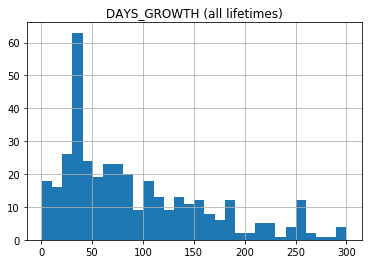

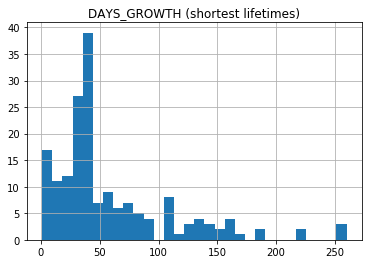

In [17]:
ddf_lifetime.select("DAYS_GROWTH").toPandas().hist(bins=30)
plt.title("DAYS_GROWTH (all lifetimes)")

ddf_lifetime.filter("ROWN=1").select("DAYS_GROWTH").toPandas().hist(bins=30)
plt.title("DAYS_GROWTH (shortest lifetimes)")

In [ ]:
import datetime
BATCH = str(datetime.datetime.today().date())
parquet_dir = "../data/Measurements/prepared-datasets/lifetimes_parquet/BATCH={BATCH}/".format(BATCH=BATCH)
BATCH

In [ ]:
ddf_lifetime_clean = ddf_lifetime.selectExpr(["`%s` as %s" % (c,c.replace(" ", "_").upper()) for c in ddf_lifetime.columns])
ddf_lifetime_clean.write.parquet(parquet_dir)

# Join and aggregate in sensor data

In [ ]:
ddf_sensor = spark.read.parquet("../data/Measurements/prepared-datasets/sensor_data_parquet/BATCH=2018-11-06")
ddf_lifetimes = spark.read.parquet("../data/Measurements/prepared-datasets/lifetimes_parquet/BATCH=2018-11-06")

In [ ]:
ddf_sensor.registerTempTable("SENSOR")
ddf_lifetimes.registerTempTable("LIFETIMES")

In [ ]:
spark.sql("""
select * from 
""")

# Early checks


In [ ]:
df_lifetimes = ddf_lifetime.filter("ROWN=1").toPandas()
df_lifetimes

In [ ]:
sns.regplot(x=df_lifetimes.DAYS_GROWTH, y=df_lifetimes.TOTAL_WEIGHT)

In [ ]:
filt = df_lifetimes[df_li]
sns.regplot(x=df_lifetimes.DAYS_GROWTH, y=df_lifetimes.TOTAL_WEIGHT)

In [ ]:
# what if we are a bit stricter on the data...
df_lifetimes_exact = df_lifetimes[df_lifetimes['Product']==df_lifetimes['Plant type']]
sns.regplot(x=df_lifetimes_exact.DAYS_GROWTH, y=df_lifetimes_exact.TOTAL_WEIGHT)

In [ ]:
df_lifetimes.hist()

In [ ]:
for p,g in df_lifetimes.groupby("Plant type"):
    print(p)
    print(g)
    #plt.figure()
    #sns.regplot(x=g.DAYS_GROWTH, y=g.TOTAL_WEIGHT)

In [ ]:
df_lifetimes